<a href="https://colab.research.google.com/github/palindrom615/notebooks/blob/main/grad/activethief.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ActiveThief

2014-11437 장회문

## Introduction

Model extraction attack은 victim model의 training에 쓴 secret dataset에 접근할 수 없음 -> 자체 데이터셋(thief dataset)을 구축, 그것을 victim model에 쿼리한 결과값을 데이터 + 레이블로 사용.

자체 데이터셋을 구축하는 것이 힘들 경우(의료 등), 그냥 general한 dataset을 사용(cv면 이미지, nlp면 텍스트). 두 가지 정도로 나뉘는데,
*  전체 probability space에서 sampling한 데이터를 사용하는 Synthetic Non-Problem Domain(SNPD)_(Tramer et al. 2016)_
* 공공 데이터셋에서 이미지, 텍스트 등을 추출하는 Natural Non-Problem Domain(NNPD) _(Corereia-Silva et al. 2018)_

대체로 NNPD가 좀 더 자연스러운 데이터를 써서 좀 더 나은 성능을 보이는 경향이 있다. 본 연구에서도 NNPD를 사용한다.

똑같이 NNPD를 사용한 Knockoff net과 달리 본 연구에서는 annotated data는 쓰지 않는다. 대신 pool-based knowledge(?)를 사용한다.

victim 모델의 구조를 몰라도, 심지어 구조가 CNN vs RNN처럼 달라도 본 방법을 쓰면 결과를 내는 것이 가능했다. 

victim model과 thief model 사이의 유사성 검증 measurements 종류: 
* test data를 정해놓고 *agreement*를 내서 평가 
* *transferability* of adversarial examples(?)

Model extraction attack의 방어 수법으로

* 전체 클래스 probability 대신 top 1만 보여주기
* 쿼리 보내는 패턴(query distribution)을 보고 악성 요청 차단
  * PRADA _(Juuti et al. 2019)_  (본 모델이 PRADA를 이김)

요약하자면
* activethief는 unannotated public data로 단 하나의 thief dataset을 구축해서 여러 개의 모델 탈취에 성공
* active learning으로 query-efficient하게 만드는 데 성공
* activethief는 쿼리가 natural distribution을 따라 분포하기 때문에 PRADA등의 방어기법 무효화

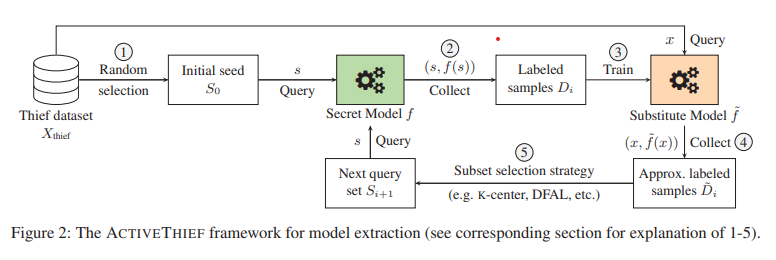

## Activethief framework

1. thief dataset에서 random한 subset을 seed $S_0$로 선택
1. $S_i$를 victim model에 먹여서 labeling($=D_i$)
1. $D_i$로 thief model $\tilde f$를 훈련시킴
1. 훈련에 사용안한 데이터 중 일부를 샘플링하고 thief model에 넣어 데이터 + 추정 레이블($\tilde{D}_i = \{(x, \tilde{f}(x))\}$)를 만듦 (마지막 activation은 full softmax)
1. $\tilde{D}_i$에 속하는 데이터 중 active learning subset selection으로 추린 것을 $S_{i+1}$로 활용

hyperparameters: 각 이터레이션 당 샘플 개수($k$), 이터레이션 수($N$), 시드 샘플 수 $|S_0|$

### Evaluation metric

agreement: thief dataset에서 test set을 분리, victim과 thief의 결과가 일치하는 데이터의 수 비율

### active learning subset selection

* random
* uncertainty _(Lewis and Gale 1994)_ - 엔트로피 값 $\mathit H = - \Sigma_j \tilde{y}_{n,j} \log \tilde{y}_{nj}  $이 최대가 되는 $x_n$ 선택
* K-center _(Sener and Savarese, 2018)_ - 본 모델이 사용. 이전에 훈련시킨 데이터 k개의 추정값들로부터 norm^2 거리가 가장 먼 k개의 데이터를 선택
* DeepFool-based Active Learning _(Ducoffe and Precioso, 2018)_ - 본 모델이 사용. DeepFool(decision boundary를 찾는 알고리즘이라고 한다. 더 찾아보기)를 이용해 decision boundary로부터의 norm^2 거리가 가장 가까운 데이터 k 개를 선택
* DFAL + K-center - K-center는 diversity가 크지만 개개 샘플이 informative하지 않고(?) DFAL는 그 반대. 본 연구에서는 DFAL로 $\rho$개(=전체 가능한 쿼리 수)를 추리고 다시 K-center로 k개를 선택.